In [336]:
#!/usr/bin/python
import json
import sys
from operator import itemgetter
from os import listdir
from os.path import isfile, join, isdir
import pandas as pd

import matplotlib.pyplot as plt

In [337]:
def collectStatistics(analyze_app, event_dir='/tmp/spark-events', memory_dir='/tmp/spark-memory'):   
    captions = ["Iteration",
                "Incremental Start",
                "Incremental End",
                "Incremental Duration",
                "Batch Start",
                "Batch End",
                "Batch Duration", 
                'Memory Min', 
                'Memory Max', 
                'Memory Mean', 'direct-used']

    data_frame = pd.DataFrame(columns=captions)
    data_frame.set_index('Iteration')

    onlyfiles = [f for f in listdir(event_dir) if isfile(join(event_dir, f)) and 'inprogress' not in f]

    for file in onlyfiles:
        with open(join(event_dir, file)) as f:
            
            content = f.readlines()
            batch_computation = False
            iteration_number = -1
            for line in content:
                event = json.loads(line)

                if event['Event'] == 'SparkListenerEnvironmentUpdate':
                    app_name = event['Spark Properties']['spark.app.name']
                    if app_name.startswith(analyze_app):
                        version = app_name.replace(analyze_app, '')
                        if not version:
                            version = '0'
                        if '_batch_' in version:
                            batch_computation = True
                            iteration_number = int(version.replace('_batch_', ''))
                            if data_frame.loc[data_frame['Iteration'] == iteration_number].empty:
                                data_frame.loc[len(data_frame)] = iteration_number

                        else:
                            batch_computation = False
                            iteration_number = int(version)
                            if data_frame.loc[data_frame['Iteration'] == iteration_number].empty:
                                data_frame.loc[len(data_frame)] = iteration_number




                if event['Event'] == 'SparkListenerJobStart':
                    start = event['Submission Time']
                    caption = 'Incremental Start'
                    if batch_computation:
                        caption = 'Batch Start'

                    data_frame.loc[data_frame['Iteration'] == iteration_number, caption] = start

                if event['Event'] == 'SparkListenerJobEnd':
                    end = event['Completion Time']
                    caption = 'Incremental End'
                    if batch_computation:
                        caption = 'Batch End'
                    data_frame.loc[data_frame['Iteration'] == iteration_number, caption] = end
                    
            if isdir(memory_dir):
                """
                 '.driver.jvm.heap.committed.csv',
                 '.driver.jvm.heap.init.csv',
                 '.driver.jvm.heap.max.csv',
                 '.driver.jvm.heap.usage.csv',
                 '.driver.jvm.heap.used.csv',
                 .driver.BlockManager.memory.memUsed_MB.csv
                """
                #mem_df = pd.read_csv(join(memory_dir, file + '.driver.jvm.heap.used.csv'))
                #mem_df = pd.read_csv(join(memory_dir, file + '.driver.jvm.heap.usage.csv'))
                try:
                    mem_df = pd.read_csv(join(memory_dir, file + '.driver.BlockManager.memory.memUsed_MB.csv'))
                    data_frame.loc[data_frame['Iteration'] == iteration_number, 'Memory Min'] = mem_df['value'].min()
                    data_frame.loc[data_frame['Iteration'] == iteration_number, 'Memory Max'] = mem_df['value'].max()
                    data_frame.loc[data_frame['Iteration'] == iteration_number, 'Memory Mean'] = mem_df['value'].mean()
                    mem_df2 = pd.read_csv(join(memory_dir, file + '.driver.jvm.direct.used.csv'))
                    data_frame.loc[data_frame['Iteration'] == iteration_number, 'direct-used'] = mem_df2['value'].mean()
                except:
                    continue
                
    data_frame['Incremental Duration'] = data_frame['Incremental End'] - data_frame['Incremental Start']
    data_frame['Batch Duration'] = data_frame['Batch End'] - data_frame['Batch Start']

    data_frame = data_frame.sort_values(['Iteration'], ascending=[True])
    data_frame = data_frame.set_index('Iteration')
    return data_frame




In [338]:
def plot_nice (res_frame, metric='Memory Mean', y_label='Megabytes', scale_function=None):
    # bytes -> kilo bytes -> mega bytes -> giga bytes 
    if scale_function:
        res_frame = res_frame.applymap(scale_function)  
    ax = res_frame[metric].plot(logy=False)
    ax.set_xlabel("GDB version")
    ax.set_ylabel(y_label)

In [387]:
def collect_logs(log_dir, app_name, suffixes=[]):
    for suffix in suffixes:
        test_name = app_name + suffix
        in_dir = log_dir + test_name
        #onlyfiles = [f for f in listdir(in_dir) if isfile(join(in_dir, f))]
        update_frame = pd.read_csv(join(in_dir, test_name + '-update-time-and-space.csv')) 
        #display(update_frame.head())
        #plot_nice(update_frame, ' Sec. Index Memory Size (bytes)', y_label='Object Size (MB)', scale_function=lambda x: x / 1024 / 1024)
        return update_frame

In [519]:
data_dir = 'dataset_data'

app_name = 'BSBM-type-memory'
app_name = 'BSBM-schemex-memory'
app_name = 'BSBM-attribute-memory'
#app_name = 'DyLDO-core-attribute-memory'

data_size_dir = 'BSBM'
#data_size_dir = 'DyLDO-core'

memory_dir = '/tmp/spark-memory'
event_dir = '/tmp/spark-events/'
log_dir = '/data13/tblume/fluid-spark/experiments/'

out_dir = 'memory_plots'

In [520]:
test1 = collectStatistics('%s-test-1' % app_name)
#test2 = collectStatistics('%s-test-2' % app_name)
#test3 = collectStatistics('%s-test-3' % app_name)

In [521]:
test1.columns

Index(['Incremental Start', 'Incremental End', 'Incremental Duration',
       'Batch Start', 'Batch End', 'Batch Duration', 'Memory Min',
       'Memory Max', 'Memory Mean', 'direct-used'],
      dtype='object')

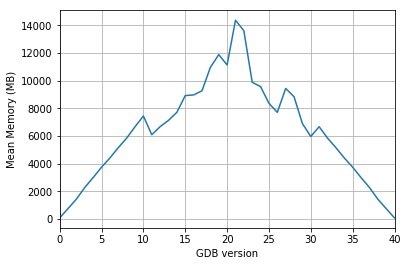

In [522]:
metric = 'Memory Max'
metric = 'direct-used'
metric = 'Memory Mean'

plot_nice(test1, metric, y_label='Mean Memory (MB)')
plt.grid(True)
plt.savefig(out_dir + '/' + app_name + '-memory.pdf', bbox_inches = 'tight')

In [523]:
update_frame = collect_logs(log_dir, app_name, suffixes=['-test-1'])

In [524]:
curr_dir = join(data_dir, data_size_dir)


onlyfiles = [f for f in listdir(curr_dir) if isfile(join(curr_dir, f)) and f.endswith(".txt")]
onlyfiles = sorted(onlyfiles)

edgecounts = {}
sizes = {}
unzipped_sizes = {}
tmp = 0
for filename in onlyfiles:
    # first line: number of types in dataset (not unique)
    # second line: number of edges in dataset (not unique)
    # third line size bytes
    f = open(join(curr_dir,filename), 'r')
    content = f.read().split('\n')
    #print(len(content))
    if len(content) > 2:
        edges = int(content[1])
    else:
        edges = int(content[0])
        
    size = int(content[2])
    
    if len(content) > 4:
        unzipped_size = int(content[3])
    
    if 'iteration' in filename:
        iteration = filename.replace('iteration', '')
        iteration = iteration.replace('-', '')
        iteration = iteration.replace('.txt', '')
        iteration = iteration.replace('.gz', '')
        iteration = iteration.replace('.nq', '')
        iteration = iteration.replace('.nt', '')
               
        edgecounts[int(iteration)] = edges
        sizes[int(iteration)] = size
        if len(content) > 4:
            unzipped_sizes[int(iteration)] = unzipped_size
        
    else:
        edgecounts[tmp] = edges
        sizes[tmp] = size
        if len(content) > 4:
            unzipped_sizes[tmp] = unzipped_size
        tmp = tmp + 1
        
edgeframe = pd.DataFrame.from_dict(edgecounts, orient='index')
edgeframe = pd.DataFrame.sort_index(edgeframe)

if len(content) > 4:
    sizeframe = pd.DataFrame.from_dict(unzipped_sizes, orient='index')
else:
    sizeframe = pd.DataFrame.from_dict(sizes, orient='index')

sizeframe = pd.DataFrame.sort_index(sizeframe)

if data_size_dir == 'DyLDO-core':    
    edgeframe = edgeframe.drop(edgeframe.index[[21,22]])
    sizeframe = sizeframe.drop(sizeframe.index[[21,22]])

sizeframe = sizeframe.applymap(lambda x: x / 1024 / 1024) 
if len(content) <= 4:
    sizeframe = sizeframe.applymap(lambda x: x * 15) 

sizeframe.columns=['Data Graph (Disk)']
#sizeframe['Memory Mean'] = test1['Memory Mean']
sizeframe['Spark Memory'] = test1['Memory Max']
sizeframe['VHI Memory'] = update_frame[' Sec. Index Memory Size (bytes)'].apply(lambda x: x / 1024 / 1024) 
sizeframe

,Data Graph (Disk),Spark Memory,VHI Memory
0,18.324519,77,1.849579
1,177.418148,755,17.119522
2,352.412623,1439,33.433716
3,530.224883,2282,50.381363
4,703.383891,2995,66.266380
5,876.509991,3742,82.144096
6,1050.754772,4413,98.024330
7,1225.032276,5154,113.906418
8,1399.339012,5844,129.785828
9,1573.699572,6668,145.668167


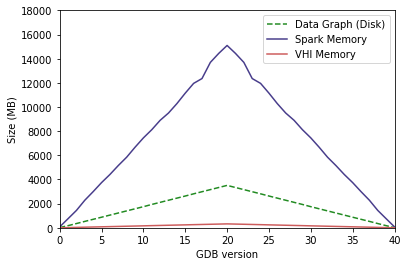

In [525]:
#print(edgeframe)
ax = sizeframe.dropna().plot(logy=False, style=['--', '-', '-', '-'], color=['forestgreen', 'darkslateblue', 'indianred', 'steelblue'])
                    
#'steelblue', 'steelblue', 'steelblue','indianred','indianred','indianred','indianred']) 

ax.set_ylabel("Size (MB)")
ax.legend(loc='upper right')
#ax = plot_frame.plot(logy=True, style=['-','--','-','--','-','--'], 
#color=['darkslateblue', 'darkslateblue', 'forestgreen', 'forestgreen', 'indianred', 'indianred'])

ax.set_xlabel("GDB version")
ax.set_ylim([0, 18000])
plt.savefig(out_dir + '/' + app_name + '-memory.pdf', bbox_inches = 'tight')    

In [526]:
overhead = sizeframe.dropna()['VHI Memory'] / sizeframe.dropna()['Spark Memory']
#display(overhead)
print(app_name)
print('memory overhead is between %.4f and %.4f (mean: %.4f +- %.4f)' % (overhead.min(), 
                                                                         overhead.max(), 
                                                                         overhead.mean(), 
                                                                         overhead.std()))

BSBM-attribute-memory
memory overhead is between 0.0213 and 0.0240 (mean: 0.0221 +- 0.0006)


In [527]:
t_frame = sizeframe.dropna()
disk_vs_memory = t_frame['Spark Memory'] / t_frame['Data Graph (Disk)']
print(app_name)
print('Memory per Disk space: %s (+- %s)' % (round(disk_vs_memory.mean(), 2), round(disk_vs_memory.std(), 2)))

BSBM-attribute-memory
Memory per Disk space: 4.23 (+- 0.06)


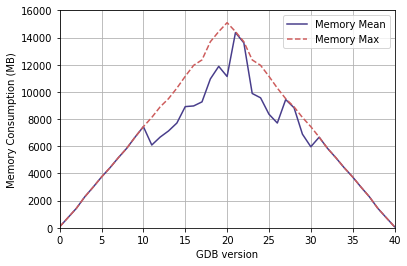

In [459]:
# plot paper


def plot_paper(res_frame, y_label='Megabytes'):
    # bytes -> kilo bytes -> mega bytes -> giga bytes 
    metric = ['Memory Mean', 'Memory Max']
    #ax = plot_frame.plot(logy=True, style=['-','--','-','--','-','--'], 
    #color=['darkslateblue', 'darkslateblue', 'forestgreen', 'forestgreen', 'indianred', 'indianred'])

    ax = res_frame[metric].plot(logy=False, style=['-','--'], color=['darkslateblue', 'indianred'])
    ax.set_xlabel("GDB version")
    ax.set_ylabel(y_label)
    ax.set_ylim([0, 16000])
    
    
plot_paper(test1, y_label='Memory Consumption (MB)')
plt.grid(True)

In [507]:
secondary_series = update_frame[' Sec. Index Memory Size (bytes)'].apply(lambda x: x / 1024 / 1024)
secondary_series

0     915.613098
1     863.868080
2     963.562164
3     959.856270
4     919.239342
5     892.404266
6     955.920280
7     928.781120
8     960.909546
9     846.121048
10    975.534760
11    853.670311
12    928.693611
13    877.919830
14    803.026337
15    951.378532
16    922.354790
17    922.025185
18    924.019539
19    878.564384
20    734.837395
Name:  Sec. Index Memory Size (bytes), dtype: float64

In [509]:
secondary_series.std()

59.322360819842885

In [448]:
primary_series = test1['Memory Mean']
primary_series

Iteration
0        77.000000
1       755.000000
2      1439.000000
3      2282.000000
4      2995.000000
5      3742.000000
6      4413.000000
7      5154.000000
8      5844.000000
9      6668.000000
10     7443.000000
11     6090.750000
12     6673.500000
13     7126.500000
14     7709.250000
15     8917.600000
16     8966.250000
17     9266.250000
18    10954.400000
19    11880.000000
20    11133.000000
21    14364.452261
22    13611.005988
23     9884.000000
24     9564.000000
25     8360.250000
26     7709.250000
27     9435.084507
28     8832.088889
29     6890.500000
30     5963.666667
31     6668.000000
32     5844.000000
33     5154.000000
34     4413.000000
35     3742.000000
36     2995.000000
37     2282.000000
38     1439.000000
39      755.000000
40       77.000000
Name: Memory Mean, dtype: float64

In [473]:
overhead = secondary_series / primary_series
#display(overhead)
print(app_name)
print('memory overhead is between %.4f and %.4f (mean: %.4f +- %.4f)' % (overhead.min(), 
                                                                         overhead.max(), 
                                                                         overhead.mean(), 
                                                                         overhead.std()))


BSBM-attribute-memory
memory overhead is between 0.0214 and 0.0298 (mean: 0.0246 +- 0.0031)


In [55]:
tests = [test1, test2, test3]

In [56]:
def mean_frames(data_frames):
    aggregated = data_frames[0].copy()
    for i in range(1, len(data_frames)):
        for label, content in data_frames[i].items():
            if not label == 'Iteration':
                for i in range(0, len(content)):
                    aggregated.at[i, label] = aggregated.at[i, label] + content[i]

    # divide all values
    for label, content in aggregated.items():
        if not label == 'Iteration':
            for i in range(0, len(content)):
                aggregated.at[i, label] = aggregated.at[i, label] / len(tests)
    return aggregated

def min_frames(data_frames):
    aggregated = data_frames[0].copy()
    for i in range(1, len(data_frames)):
        for label, content in data_frames[i].items():
            if not label == 'Iteration':
                for i in range(0, len(content)):
                    aggregated.at[i, label] = min(aggregated.at[i, label], content[i])

    return aggregated

In [386]:
import re
onlyfiles = [re.sub('local-[0-9]+', '', f) for f in listdir(memory_dir) if isfile(join(memory_dir, f))]
#display(onlyfiles)


In [62]:
types = set(onlyfiles)

In [385]:
#display(types)

,Data Graph (Disk),Spark Memory,VHI Memory
0,2405.307897,10820.0,915.613098
1,2306.354592,10462.0,863.868080
2,2790.347591,12831.0,963.562164
3,2722.321526,12454.0,959.856270
4,2383.698988,10772.0,919.239342
5,2715.887818,12321.0,892.404266
6,2771.176556,12756.0,955.920280
7,2390.870522,10611.0,928.781120
8,2792.413451,12811.0,960.909546
9,2171.313519,9898.0,846.121048


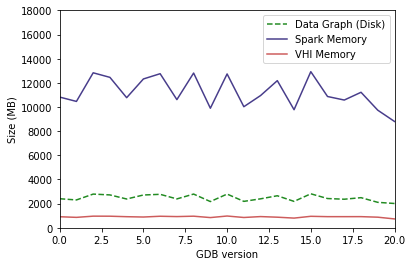

In [335]:
#ax.set_ylabel("Quantity")
#ax.yaxis.set_label_coords(-0.015,1.0)
#plt.xticks(np.arange(0, 50, 5.0))
print("MAX: " + str(edgeframe.max()))
print("MIN: " + str(edgeframe.min()))
display(edgeframe.head())

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), shadow=True, ncol=4)

MAX: 0    11566501
dtype: int64
MIN: 0    6145732
dtype: int64


,0
0,9653266
1,9220298
2,11517193
3,11273950
4,9465024


In [300]:
test1[metric]

Iteration
0     10047.142857
1     10430.296970
2     11761.750000
3     11564.428571
4     10728.388664
5     12313.366171
6     12428.923077
7      9903.600000
8     12057.411765
9      9873.255000
10    12028.444444
Name: Memory Mean, dtype: float64